# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [4]:
data.info()
data.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

0

In [5]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


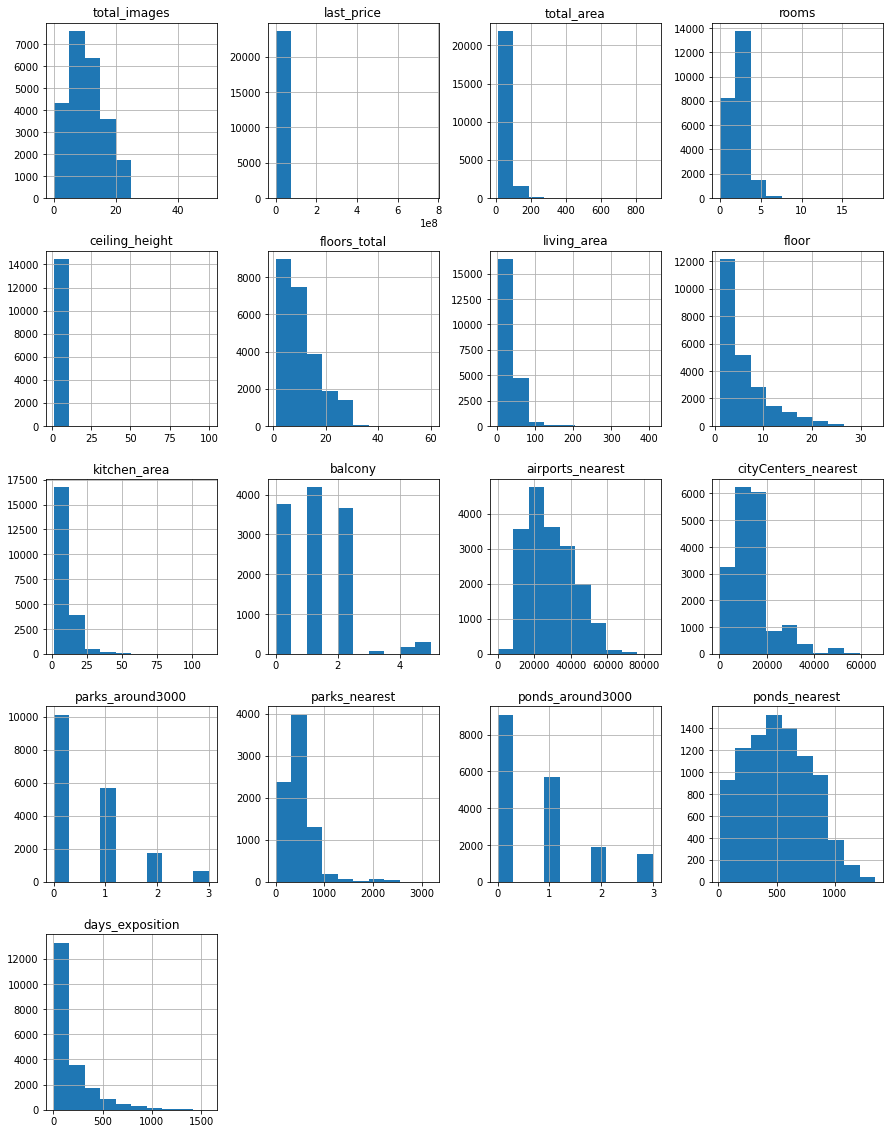

In [6]:
data.hist(figsize=(15, 20));

**Вывод:** Всего 23699 строчек. Во многих столбцах есть пропущенные значения, а также указан некорректный тип данных. Явных дубликатов нет.

### Выполните предобработку данных

In [7]:
#найдем количество пропущенных значений в каждом столбце
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

**Вывод:** Пропуски в столбцах 'balcony' можно объяснить тем, что балконов в квартире просто нет, а в столбце 'is_apartment' тем, что жилое помещение не является апартаментом. Можно сделать предположение, что пропуски в 'kitchen_area', 'living_area' обусловлены тем, что преимущественно указывают всю площадь жилого помещения, не разделяя отдельно на площадь кухни и площадь жилого помещения, что подтверждается отсутствием пропусков в 'total_area'. Пропуски в 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest' скорее можно обьяснить тем, что объекты исследования находятся далеко от центра, парков, и прудов.

In [8]:
data.rename(columns = {'cityCenters_nearest':'city_centers_nearest', 'parks_around3000':'parks_around_3000', 'ponds_around3000':'ponds_around_3000'}, inplace=True)

In [9]:
#меняем тип данных в колонке first_day_exposition
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')

In [10]:
#приводим колонку last_price к целочисленному типу
data['last_price'] = data['last_price'].astype('int')

In [11]:
#меняем NaN на медианное значение в ceiling_height
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

In [12]:
print(data['ceiling_height'].sort_values(ascending=False).head(30))

22869    100.0
3148      32.0
22336     32.0
21377     27.5
4876      27.0
17857     27.0
5246      27.0
20478     27.0
22938     27.0
5807      27.0
21824     27.0
10773     27.0
5669      26.0
18545     25.0
4643      25.0
9379      25.0
11285     25.0
14382     25.0
355       25.0
6246      25.0
5076      24.0
20507     22.6
17496     20.0
15061     14.0
22309     10.3
5863       8.3
3474       8.0
15743      8.0
17442      8.0
20264      6.0
Name: ceiling_height, dtype: float64


In [13]:
#меняем явные ошибки в ceiling_height
data.loc[data['ceiling_height'] >= 20.0, 'ceiling_height'] = data['ceiling_height']/10

In [14]:
print(data['ceiling_height'].sort_values(ascending=False).head(30))

15061    14.00
22309    10.30
22869    10.00
5863      8.30
17442     8.00
15743     8.00
3474      8.00
20264     6.00
21227     5.80
1388      5.60
7578      5.50
1026      5.30
12628     5.30
464       5.20
1053      5.00
21923     4.90
2802      4.80
19142     4.70
1300      4.70
12401     4.65
6802      4.50
14519     4.50
13224     4.50
10159     4.50
2823      4.50
9783      4.50
3067      4.50
8018      4.45
7521      4.45
6728      4.40
Name: ceiling_height, dtype: float64


In [15]:
#удаляем записи, где отсутствует значения в колонке floors_total
data.dropna(subset=['floors_total'], inplace=True)

In [16]:
#приводим колонку floors_total к целочисленному типу
data['floors_total'] = data['floors_total'].astype(int)

In [17]:
#заполняем пропущенные значения в колонке is_apartment на 'False'
data['is_apartment'] = data['is_apartment'].fillna(False)

In [18]:
#приводим этажность к целочисленному типу
data['is_apartment'] = data['is_apartment'].astype('bool')

In [19]:
#добавим колонку с значениями отношения площади кухни к общей площади
data['kitchen_area_ratio'] = data['kitchen_area'] / data['total_area']
print(data['kitchen_area_ratio'].head())

0    0.231481
1    0.272277
2    0.148214
3         NaN
4    0.410000
Name: kitchen_area_ratio, dtype: float64


In [20]:
#найдем средний коэффициент отношения площади кухни к общей площади
kitchen_area_ratio_mean = data['kitchen_area_ratio'].mean()
print(kitchen_area_ratio_mean)

0.18732402442071253


In [21]:
#заполним пропущенные значения в колонке kitchen_area_ratio
data['kitchen_area_ratio'] = data['kitchen_area_ratio'].fillna(kitchen_area_ratio_mean)
print(data['kitchen_area_ratio'].head())

0    0.231481
1    0.272277
2    0.148214
3    0.187324
4    0.410000
Name: kitchen_area_ratio, dtype: float64


In [22]:
#заполняем пропущенные значения в колонке kitchen_area
data['kitchen_area'] = data['total_area'] * data['kitchen_area_ratio']

In [23]:
data['kitchen_area'].isna().sum()

0

In [24]:
#добавим колонку с значениями отношения жилой площади к общей площади
data['living_area_ratio'] = data['living_area'] / data['total_area']
print(data['living_area_ratio'].head())

0    0.472222
1    0.460396
2    0.612500
3         NaN
4    0.320000
Name: living_area_ratio, dtype: float64


In [25]:
#найдем средний коэффициент отношения жилой площади к общей площади
living_area_ratio_mean = data['living_area_ratio'].mean()
print(living_area_ratio_mean)

0.5649479605594985


In [26]:
#заполним пропущенные значения в колонке living_area_ratio
data['living_area_ratio'] = data['living_area_ratio'].fillna(living_area_ratio_mean)
print(data['living_area_ratio'].head())

0    0.472222
1    0.460396
2    0.612500
3    0.564948
4    0.320000
Name: living_area_ratio, dtype: float64


In [27]:
#заполняем пропущенные значения в колонке living_area
data['living_area'] = data['total_area'] * data['living_area_ratio']

In [28]:
data['living_area'].isna().sum()

0

In [29]:
#заполняем пропущенные значения в колонке balcony на 0
data['balcony'] = data['balcony'].fillna(0)

In [30]:
#приводим колонку balcony к целочисленному типу
data['balcony'] = data['balcony'].astype('int')

In [31]:
#заполняем пропущенные значения в колонке parks_around_3000 на 0
data['parks_around_3000'] = data['parks_around_3000'].fillna(0)

In [32]:
#приводим колонку parks_around_3000 к целочисленному типу
data['parks_around_3000'] = data['parks_around_3000'].astype(int)

In [33]:
#заполняем пропущенные значения в колонке ponds_around_3000 на 0
data['ponds_around_3000'] = data['ponds_around_3000'].fillna(0)

In [34]:
#приводим колонку ponds_around_3000 к целочисленному типу
data['ponds_around_3000'] = data['ponds_around_3000'].astype(int)

In [35]:
#приводим значения в колонке locality_name к нижнему регистру
data['locality_name'] = data['locality_name'].str.lower()

In [36]:
#избавляемся от явных дубликатов в колонке locality_name
data['locality_name'] = (
    data['locality_name']
    .str.replace('ё','е')
    .replace(['поселок ','при железнодорожной станции ', 'платформа ', 'садоводческое некоммерческое товарищество ',
              'садовое товарищество ', 'станции ', 'село ', 'пансионат ', 'городского типа ',
              'деревня ', 'городской поселок '], '', regex=True)
)

In [37]:
print(data['locality_name'].unique())

['санкт-петербург' 'шушары' 'городской янино-1' 'парголово' 'мурино'
 'ломоносов' 'сертолово' 'петергоф' 'пушкин' 'кудрово' 'коммунар'
 'колпино' 'красный бор' 'гатчина' 'федоровское' 'выборг' 'кронштадт'
 'кировск' 'новое девяткино' 'металлострой' 'лебяжье' 'сиверский'
 'молодцово' 'кузьмоловский' 'новая ропша' 'павловск' 'пикколово'
 'всеволожск' 'волхов' 'кингисепп' 'приозерск' 'сестрорецк' 'куттузи'
 'аннино' 'ефимовский' 'плодовое' 'заклинье' 'торковичи' 'первомайское'
 'красное село' 'понтонный' 'сясьстрой' 'старая' 'лесколово' 'новый свет'
 'сланцы' 'путилово' 'ивангород' 'шлиссельбург' 'никольское' 'зеленогорск'
 'сосновый бор' 'оржицы' 'кальтино' 'романовка' 'бугры' 'рощино' 'кириши'
 'луга' 'волосово' 'отрадное' 'павлово' 'оредеж' 'копорье' 'молодежное'
 'тихвин' 'победа' 'нурма' 'синявино' 'тосно' 'стрельна' 'бокситогорск'
 'александровская' 'лопухинка' 'пикалево' 'терволово' 'советский'
 'подпорожье' 'петровское' 'токсово' 'сельцо' 'вырица' 'кипень' 'келози'
 'вартемяги' 'т

In [38]:
#удаляем записи, где отсутствует значения в колонке locality_name
data = data.dropna(subset=['locality_name'])

In [39]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5524
city_centers_nearest     5501
parks_around_3000           0
parks_nearest           15535
ponds_around_3000           0
ponds_nearest           14529
days_exposition          3171
kitchen_area_ratio          0
living_area_ratio           0
dtype: int64

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  int64         
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  int64         
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23565 non-null  float64       
 13  balcony         

**Общие выводы по разделу:**
    Основными причинами пропусков могли стать человеческий фактор (ошибка ввода), а также програмные сбои, в виду ее доработки. 
    
    В процессе предобработки данных:    
 * переименованы столбцы в соответствии с хорошим стилем - cityCenters_nearest' в 'city_centers_nearest', 'parks_around3000' в 'parks_around_3000', 'ponds_around3000' в 'ponds_around_3000';
 * преобразован тип данных в соответствии с данными, находяшимися в столбцах - колонки 'last_price', 'floors_total', 'balcony', 'parks_around_3000', 'ponds_around_3000' могут содержать только целые числа, 'first_day_exposition' содержит время, 'is_apartment' содержит булевы значения
 * заполнены явные пропуски в таблице.

### Добавьте в таблицу новые столбцы

In [41]:
#посчитаем ценe одного квадратного метра и добавим колонку в общий Dataframe
data['price_per_square_meter'] = (data['last_price']/data['total_area']).round(2)

In [42]:
print(data['price_per_square_meter'].head(10))

0    120370.37
1     82920.79
2     92785.71
3    408176.10
4    100000.00
5     95065.79
6     99195.71
7    110544.69
8     87454.76
9     88524.59
Name: price_per_square_meter, dtype: float64


In [43]:
#добавим столбец, содержащйй день публикации в общий Dataframe
data['day_publication'] = data['first_day_exposition'].dt.weekday

In [44]:
#добавим столбец, содержащйй месяц публикации в общий Dataframe
data['month_publication'] = data['first_day_exposition'].dt.month

In [45]:
#добавим столбец, содержащйй год публикации в общий Dataframe
data['years_publication'] = data['first_day_exposition'].dt.year

In [46]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,kitchen_area_ratio,living_area_ratio,price_per_square_meter,day_publication,month_publication,years_publication
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,False,...,482.0,2,755.0,NaN,0.231481,0.472222,120370.37,3,3,2019
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.600000,1,False,...,NaN,0,NaN,81.0,0.272277,0.460396,82920.79,1,12,2018
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.300000,4,False,...,90.0,2,574.0,558.0,0.148214,0.612500,92785.71,3,8,2015
3,0,64900000,159.0,2015-07-24,3,2.65,14,89.826726,9,False,...,84.0,3,234.0,424.0,0.187324,0.564948,408176.10,4,7,2015
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,False,...,112.0,1,48.0,121.0,0.410000,0.320000,100000.00,1,6,2018


In [47]:
#добавим столбец, содержащйй тип этажа квартиры в общий Dataframe
def floor(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['floor_group'] = data.apply(floor, axis=1)

In [48]:
#добавим столбец, содержащйй расстояние до центра города в километрах в общий Dataframe
data['distance_city_center'] = (data['city_centers_nearest'] / 1000).round(0)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,kitchen_area_ratio,living_area_ratio,price_per_square_meter,day_publication,month_publication,years_publication,floor_group,distance_city_center
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,False,...,755.0,NaN,0.231481,0.472222,120370.37,3,3,2019,другой,16.0
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.600000,1,False,...,NaN,81.0,0.272277,0.460396,82920.79,1,12,2018,первый,19.0
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.300000,4,False,...,574.0,558.0,0.148214,0.612500,92785.71,3,8,2015,другой,14.0
3,0,64900000,159.0,2015-07-24,3,2.65,14,89.826726,9,False,...,234.0,424.0,0.187324,0.564948,408176.10,4,7,2015,другой,7.0
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,False,...,48.0,121.0,0.410000,0.320000,100000.00,1,6,2018,другой,8.0


### Проведите исследовательский анализ данных

#### Изучим параметры объектов и построим для каждого отдельную гистограмму

In [49]:
#изучим столбец total_area
data['total_area'].describe()

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

Оставим значения от минимального 12 до 100 кв. для проведения качественного анализа

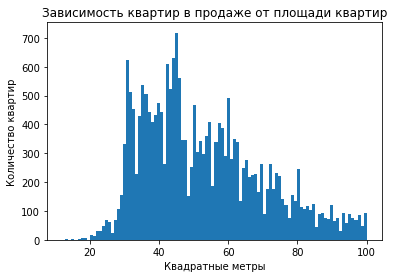

In [50]:
plt.hist(data['total_area'], bins=100, range=(12,100))
plt.title('Зависимость квартир в продаже от площади квартир')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество квартир')
plt.show()

**Вывод:** Больше всего квартир на рынке площадью от 40 до 69 кв.метров, максимум 52 кв.метра

In [51]:
#изучим столбец living_area
data['living_area'].describe()

count    23565.000000
mean        34.561055
std         22.346086
min          2.000000
25%         19.000000
50%         30.000000
75%         42.100000
max        409.700000
Name: living_area, dtype: float64

Оставим значения от минимального 12 до 39 кв. для проведения качественного анализа

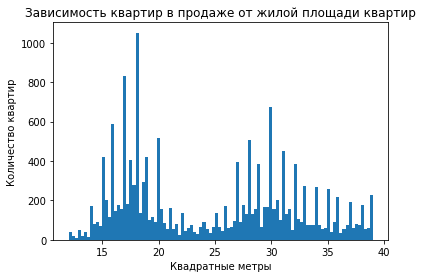

In [52]:
plt.hist(data['living_area'], bins=100, range=(12,39))
plt.title('Зависимость квартир в продаже от жилой площади квартир')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество квартир')
plt.show()

**Вывод:** Больше всего квартир на рынке с жилой площадью 18 и 30 кв.метров

In [53]:
#изучим столбец kitchen_area
data['kitchen_area'].describe()

count    23565.000000
mean        10.565298
std          6.093122
min          1.300000
25%          7.000000
50%          9.000000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

Оставим значения от минимального 5 до 15 кв. для проведения качественного анализа

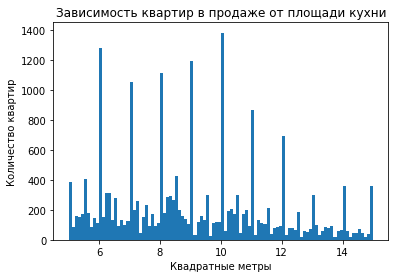

In [54]:
plt.hist(data['kitchen_area'], bins=100, range=(5,15))
plt.title('Зависимость квартир в продаже от площади кухни')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество квартир')
plt.show()

**Вывод:** На рынке больше всего предложений с площадью кухни в 6 и 10 кв.метров. Эти яркие всплески частично можно обьяснить тем, что это типовые значения площади кухни для отдельных серий домов.

In [55]:
#изучим столбец last_price
data['last_price'].describe()

count    2.356500e+04
mean     6.540058e+06
std      1.091093e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.646000e+06
75%      6.790000e+06
max      7.630000e+08
Name: last_price, dtype: float64

Оставим значения от минимального 430000р. до 9500000р. для проведения качественного анализа

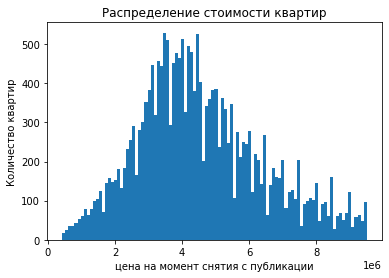

In [56]:
plt.hist(data['last_price'], bins=100, range=(430000,9500000))
plt.title('Распределение стоимости квартир')
plt.xlabel('цена на момент снятия с публикации')
plt.ylabel('Количество квартир')
plt.show()

**Вывод:** Гистограмма показывает, что самая встречающаяся цена объекта в среднем от 3.7 до 4.3 миллиона рублей

In [57]:
#изучим столбец rooms
data['rooms'].describe()

count    23565.000000
mean         2.070656
std          1.078591
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

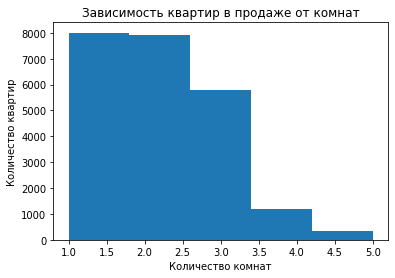

In [58]:
plt.hist(data['rooms'], bins=5, range=(1,5))
plt.title('Зависимость квартир в продаже от комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Количество квартир')
plt.show()

**Вывод:** Гистограмма показывает, что с увеличением числа комнат количество предложений уменьшается.

In [59]:
#изучим столбец ceiling_height
data['ceiling_height'].describe()

count    23565.000000
mean         2.698746
std          0.253630
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         14.000000
Name: ceiling_height, dtype: float64

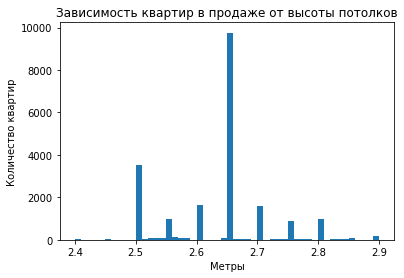

In [60]:
plt.hist(data.query('(ceiling_height > 2) & (ceiling_height < 4)')['ceiling_height'], bins=50, range=(2.4,2.9))
plt.title('Зависимость квартир в продаже от высоты потолков')
plt.xlabel('Метры')
plt.ylabel('Количество квартир')
plt.show()

**Вывод:** Больше всего предложений на рынке у объектов, где высота потолка составляет 2,65м.

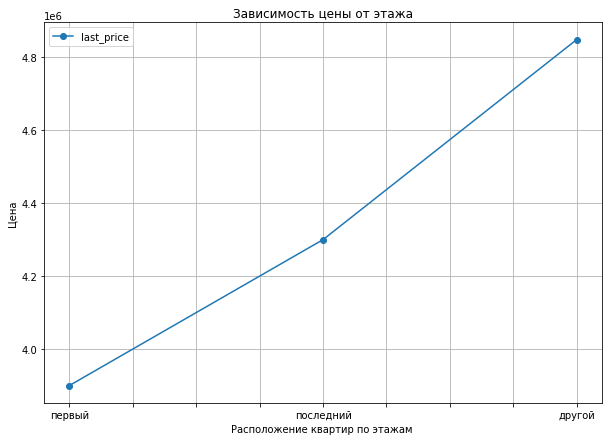

In [61]:
data.pivot_table(index='floor_group', values='last_price', aggfunc='median').sort_values(by='last_price') \
.plot(grid=True, style='o-', figsize=(10,7), title='Зависимость цены от этажа')
plt.xlabel('Расположение квартир по этажам ')
plt.ylabel('Цена')
plt.show()

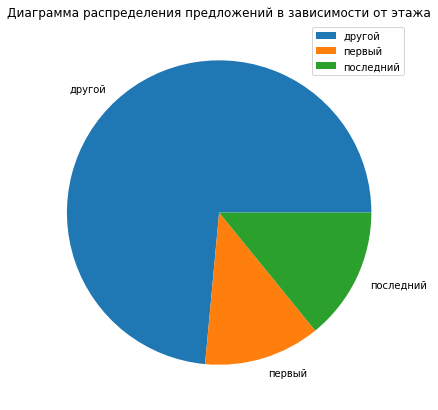

In [62]:
data.pivot_table(index='floor_group',values='last_price',aggfunc='count') \
  .plot.pie(y='last_price', figsize=(10,7), label='', title='Диаграмма распределения предложений в зависимости от этажа')
plt.show()

**Вывод:** Квартиры, находящиеся на первом и последнем этаже,  по доле предложений явно уступают оставшимся квартирам, но находятся примерно в равном соотношении друг с другом

In [63]:
#изучим столбец floors_total
data['floors_total'].describe()

count    23565.000000
mean        10.675875
std          6.594823
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Оставим значения от минимального 1 до 30, так как дома выше встречаются редко

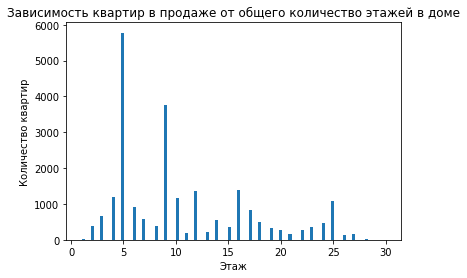

In [64]:
plt.hist(data['floors_total'], bins=100, range=(1,30))
plt.title('Зависимость квартир в продаже от общего количество этажей в доме')
plt.xlabel('Этаж')
plt.ylabel('Количество квартир')
plt.show()

**Вывод:** Больше всего предложений на рынке в пятиэтажных и девятиэтажных домах. Можно сделать предположение, что это квартиры "Хрущевки" старого типа.

In [65]:
#изучим столбец city_centers_nearest
data['city_centers_nearest'].describe()

count    18064.000000
mean     14192.656056
std       8613.348153
min        181.000000
25%       9238.000000
50%      13096.500000
75%      16285.000000
max      65968.000000
Name: city_centers_nearest, dtype: float64

Оставим значения от 0 до 25000м, так как расстояние свыше можно уже могут относиться к другому населенному пункту

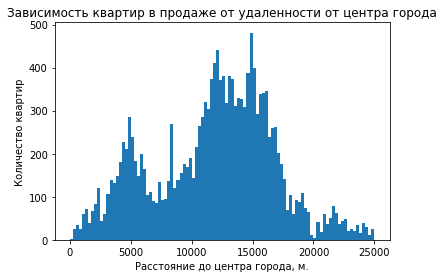

In [66]:
plt.hist(data['city_centers_nearest'], bins=100, range=(0,25000))
plt.title('Зависимость квартир в продаже от удаленности от центра города')
plt.xlabel('Расстояние до центра города, м.')
plt.ylabel('Количество квартир')
plt.show()

**Вывод:** Больше всего предложений на рынке на расстоянии от 12 до 15км. Также есть всплески на расстоянии в 5 и 7км от центра города

In [67]:
#изучим столбец parks_nearest
data['parks_nearest'].describe()

count    8030.000000
mean      490.580448
std       341.572956
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

Оставим значения от 0 до 1000м

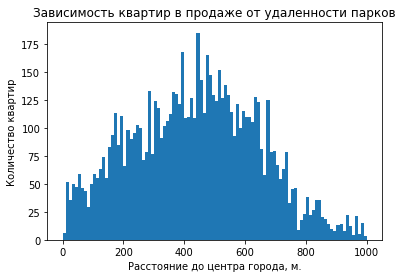

In [68]:
plt.hist(data['parks_nearest'], bins=100, range=(0,1000))
plt.title('Зависимость квартир в продаже от удаленности парков')
plt.xlabel('Расстояние до центра города, м.')
plt.ylabel('Количество квартир')
plt.show()

**Вывод:** Нет сильной зависимости количества предложений от удаленности от ближайшего парка. По всей видимости этот критерий не является решающим при выборе объекта для покупки

**Общие выводы по разделу:** 
    В результате исследовательского анализа определенных параметров было установлено:    
 * больше всего продаж пришлось на объекты с площадью от 40 до 69 кв.метров с пиком в 52 кв.метра;
 * из них, больше всего квартир на рынке с жилой площадью 18 и 30 кв.метров;
 * больше всего предложений, в которых площадь кухни составляет 6 и 10 кв.метров. Обьясняется тем, что эти типовые значения площади кухни для отдельных серий домов;
 * самая встречающаяся цена объекта в среднем от 3.7 до 4.3 миллиона рублей;
 * с увеличением числа комнат количество предложений уменьшается;
 * большинство предложений приходится на объекты, где высота потолка составляет 2,65м;
 * квартиры на первом и последнем этаже пользуются гораздо меньшим спросом, чем квартиры на других этажах;
 * большинство предложений приходится на пятиэтажные и девятиэтажные дома - скорее всего это "Хрущевки";
 * наиболее часто встречаются объекты на расстоянии от 12 до 15км. от центра города;
 * сильной зависимости количества предложений от удаленности от ближайшего парка не прослеживается.

#### Изучим, как быстро продавались квартиры

In [69]:
#изучим как быстро продавались квартиры
data['days_exposition'].describe()

count    20394.000000
mean       180.741395
std        219.732782
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

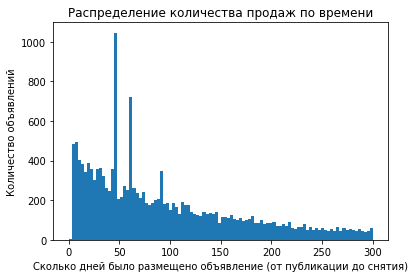

In [70]:
plt.hist(data['days_exposition'], bins=100, range=(0,300))
plt.title('Распределение количества продаж по времени')
plt.xlabel('Сколько дней было размещено объявление (от публикации до снятия)')
plt.ylabel('Количество объявлений')
plt.show()

**Вывод:** Среднее значение продажи квартиры - 180 дней, но лучше ориентироваться на медианное значение в 95 дней, которое не подвержено влиянию выбросов. То есть в среднем срок продажи квартиры составляет примерно 3 месяца с момента публикации объявления. Быстрыми продажами можно считать срок в 45 дней, а необычно долгими в 231 день и дольше.

#### Изучим факторы, которые больше всего влияют на общую стоимость объекта

Перед изучением факторов избавимся от выбросов и аномальных значений, чтобы они не выходили за рамки на расстояние, равное 1,5 межквартильного размаха:

In [71]:
#зададим собственнную функцию def для подсчёта границ с учетом 1.5 размаха
def quartile_range(data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    dataq = data.loc[(data[column] < q3 + 1.5*iqr) & (data[column] > q1 - 1.5*iqr), column]
    return dataq
#столбцы с выбросами
outliers = ['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms', 'ceiling_height' ]
for col in outliers:
    data[col] = quartile_range(data, col)

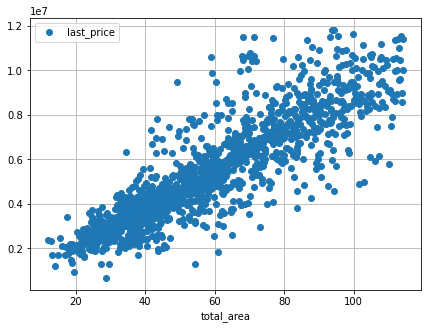

0.6940523107096932

In [72]:
#изучим зависимость цены от общей площади
data.pivot_table(index='total_area', values='last_price').plot(grid=True, style='o', figsize=(7, 5))
plt.show()
data['total_area'].corr(data['last_price'])

**Вывод:** С увеличением общей площади объекта стоимость растет линейно

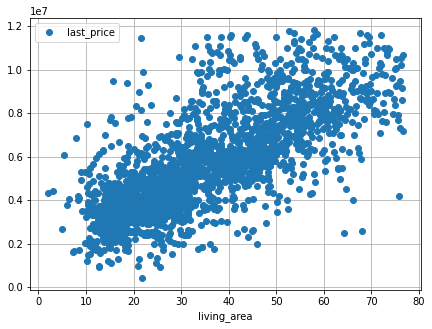

0.5735565884314315

In [73]:
#изучим зависимость цены от жилой площади
data.pivot_table(index='living_area', values='last_price').plot(grid=True, style='o', figsize=(7, 5))
plt.show()
data['living_area'].corr(data['last_price'])

**Вывод:** С увеличением жилой площади объекта стоимость также растет линейно

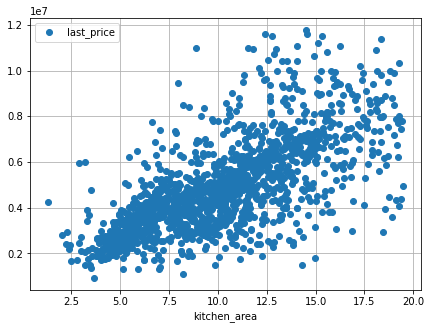

0.506619173475033

In [74]:
#изучим зависимость цены от площади кухни
data.pivot_table(index='kitchen_area', values='last_price').plot(grid=True, style='o', figsize=(7, 5))
plt.show()
data['kitchen_area'].corr(data['last_price'])

**Вывод:** Прямой зависимости цены от площади кухни не прослеживается

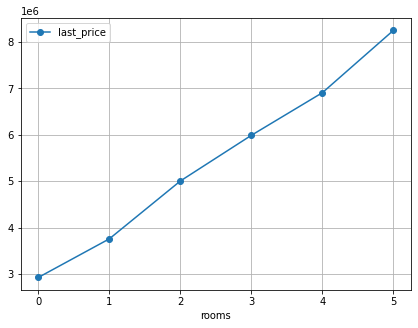

0.44890734170263413

In [75]:
#изучим зависимость цены от количества комнат
data.pivot_table(index='rooms', values='last_price').plot(grid=True, style='o-', figsize=(7, 5))
plt.show()
data['rooms'].corr(data['last_price'])

**Вывод:** Количество комнат напрямую влияет на стоимость объекта, цена линейно растет с их увеличением 

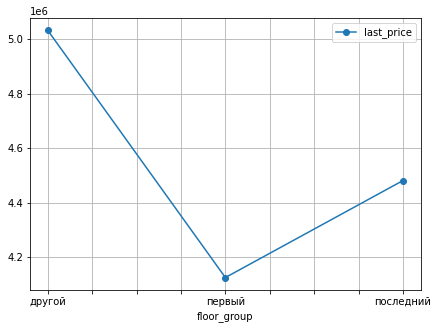

In [76]:
#изучим зависимость цены от этажности объекта
data.pivot_table(index='floor_group', values='last_price').plot(grid=True, style='o-', figsize=(7, 5))
plt.show()

**Вывод:** Стоимость объектов на первом этаже в среднем на 400 тысяч ниже, чем на последнем этаже и практически на миллион дешевле, чем на других этажах. 

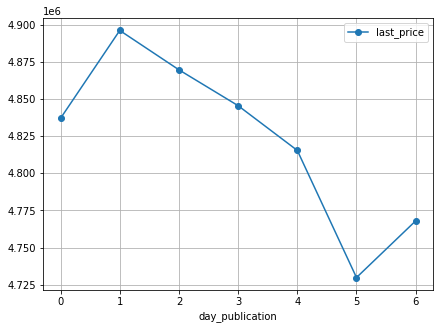

-0.015812293600318467

In [77]:
#изучим зависимость цены от дня публикации
data.pivot_table(index='day_publication', values='last_price').plot(grid=True, style='o-', figsize=(7, 5))
plt.show()
data['day_publication'].corr(data['last_price'])

**Вывод:** Сложно объяснить, почему пик цены приходится на вторник, а не на понедельник. Хотя из личного опыта могу сказать, что из-за большой загруженности в выходные дни, агенты часто берут выходной день в понедельник, а во вторник возобновляют свою активную профессиональную деятельность и выставляют на продажу объекты. Можно с этим связать данный пик.

Хотел уточнить: на любой площадке, будь это Авито или Яндекс можно снизить цену объекта. Так вот как реагирует в данном случае автоматизированная система Яндекса? Если я объект на продаже выставлен в среду, а цену поменяли в воскресенье, система выдаст именно среду как день публикации? 

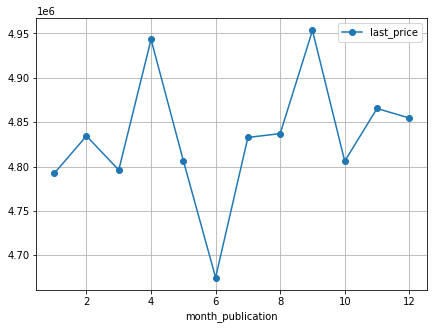

In [78]:
#изучим зависимость цены от месяца публикации
data.pivot_table(index='month_publication', values='last_price').plot(grid=True, style='o-', figsize=(7, 5))
plt.show()

**Вывод:** Спад в июне может быть связан с сезоном отпусков. Явный пик в апреле можно связать с тем, что люди в теплый период активнее занимаются поиском и продажей недвижимости, так как в более холодное время года это менее удобно и комфортно, в том числе из-за погодных явлений.

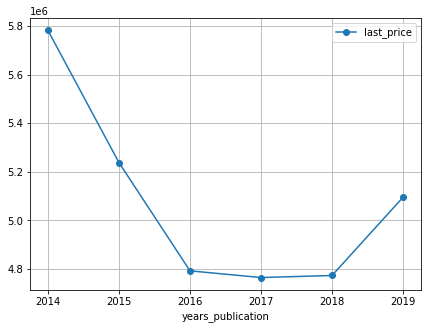

In [79]:
#изучим зависимость цены от года публикации
data.pivot_table(index='years_publication', values='last_price').plot(grid=True, style='o-', figsize=(7, 5))
plt.show()

**Вывод:** По графику можно предположить, что пик в 2014 году пришелся на обвал курса рубля и люди начали экстренно искать, куда вложить накопленные средства. Ничего лучше недвижимости еще не придумали. Далее спрос на недвижимость упал. Рост с 2018 года говорит о стабилизации национальной валюты и способности граждан вновь приобретать жилье.

**Общие вывод:** Основными факторами, вляиющими на общую стоимость объекта являются общая площадь, жилая площадь объекта и количество комнат. С ростом этих параметров, стоимость недвижимости также растет. Показано, что наименьшим спросов пользуются объекты на 1 этаже. 

#### Посчитаем среднюю цену одного квадратного метра в  населенных пунктах с наибольшим числом объявлений

In [80]:
top_squad_price = data.pivot_table(index='locality_name', values='last_price', aggfunc=['count'])
top_squad_price.columns = ['count']
top_squad_price = top_squad_price.sort_values(by='count', ascending=False).head(10)
top_squad_price['price_per_square_meter'] = data.pivot_table(index='locality_name', values='price_per_square_meter').round(2)
top_squad_price.sort_values(by='price_per_square_meter', ascending=False)

,count,price_per_square_meter
locality_name,,
санкт-петербург,13676,114868.88
пушкин,338,103125.82
кудрово,468,95260.85
парголово,327,90175.91
мурино,586,86041.12
шушары,439,78551.34
колпино,336,75424.58
гатчина,305,68746.15
всеволожск,397,68654.47


**Вывод:** Ожидаемо, наибольшая цена квадратного метра в Санкт-Петербурге. Далее идет Пушкин, что можно обьяснить большим количеством парков. Низкую цену объектов  в Выборге и Всеволожске можно объяснить большой удаленностью от Санкт-Петербурга 

#### Вычислим среднюю стоимость квартир в Санкт-Петербурге на разном удалении от центра

In [81]:
#изучим данные по удаленности от центра Санкт-Петербурга
data.query('locality_name == "санкт-петербург"')['distance_city_center'].describe()

count    15591.000000
mean        11.583414
std          4.854068
min          0.000000
25%          8.000000
50%         12.000000
75%         15.000000
max         29.000000
Name: distance_city_center, dtype: float64

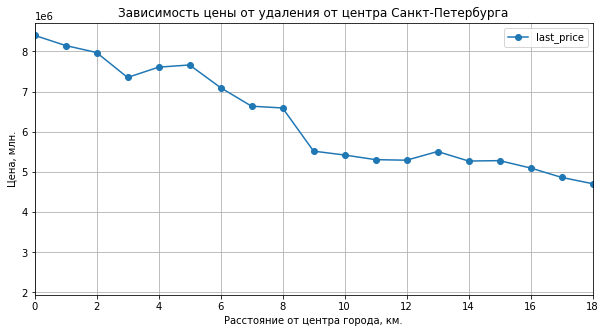

In [82]:
#согласно данным, сделаем срез от 0 до 18км.
data.query('locality_name == "санкт-петербург"').pivot_table(index='distance_city_center', values='last_price').plot(grid=True, style='o-', xlim=(0,18), figsize=(10, 5))
plt.title('Зависимость цены от удаления от центра Санкт-Петербурга')
plt.xlabel('Расстояние от центра города, км.')
plt.ylabel('Цена, млн.')
plt.show()

In [83]:
#построим таблицу стоимости объектов на разном удалении от центра Санкт-Петребурга
data.query('locality_name == "санкт-петербург" and distance_city_center<18').pivot_table(values='last_price', index='distance_city_center')

,last_price
distance_city_center,
0.0,8.398000e+06
1.0,8.145277e+06
2.0,7.970519e+06
3.0,7.350003e+06
4.0,7.606618e+06
5.0,7.661225e+06
6.0,7.096569e+06
7.0,6.635321e+06
8.0,6.591220e+06


**Вывод:** Ожидаемо, самая большая стоимость объекта в центре города. С увеличением расстояния от центра стоимость падает, однако можно заметить, что на 4 и 5 км цена вновь возрастает. Скорее всего там находятся Василеостровский район, который считается одним из самых престижных в городе. Начиная с 9 километра, стоимость практически не изменяется.

### Напишите общий вывод

В данной работе были проанализированы объявления о продаже квартир в Санкт-Петербурге и в его пригородах.

На первоначальном этапе работы были обработаны данные и заполнены пропуски, где это было необходимо и была такая возможность. При сборе данных стоит обратить внимание коллег на заполняемость данных, либо на процесс выгрузки данных из программы, так как в некоторых колонках количество пропусков превышает 50%. Корректно выгруженные данные значительно уменьшают время анализа, а также быстрее позволяют предоставить готовый результат. Ошибки, обусловленные человеческим фактором, встречались гораздо реже.

Пропуски заполнялись в основном медианными значениями или нулями из-за отсутствия тех или иных параметров. Особую опасность представляли значения в колонке locality_name, где один и тот же населенный пункт мог встречаться 3 раза, но под разными названиями. Строки с пропусками в данных колонках были удалены, так как не было никакого смысла проводить анализ из-за отсутствия понимания, где находится объект. 

Для дальнейшего удобства работы с данными в датафрейм также были добавлены данные цены одного квадратного метра, день, месяц, год публикации, тип квартиры, а также расстояние от центра города в километрах.

После преобработки данных были изучены ключевые параметры. Так установлено, что преимущественно на рынке продаются квартиры площадью 52 кв.метра, в среднем от 3,7 до 4,3 млн.рублей, находящиеся пятиэтажных и девятиэтажных домах, преимущественно однокомнатные и двухкомнатные, с высотой потолка 2,65м., что идеально вписывается под тип "Хрущевка". Анализ ожидаемо показал, что стоимость объекта линейно растет с увеличением площади квартиры и количества комнат. Стандартный срок продажи объекта составляет около 3 месяцев. Данные подтвердили гипотезу, что самая большая стоимость квадратного метра в Санкт-Петербурге. И целом, чем дальше от Санкт-Петербурга и его центра, стоимость жилья линейно уменьшается.

Резюмируя, можно сделать вывод, что цена объекта главным образом зависит от его площади. Этажность не влияет на цену, если это не последний, и в особенности не первый этаж. В основном, на рынке продаются хрущевки с 1 или 2 комнатами. 

Было бы интересно проанализировать, насколько опустилась цена относительно первоначальной, применительно к каждому объекту и насколько это ускоряло процесс продажи. Сравнить по каждому населенному пункту показатель скорости продажи объектов с занижением исходной цены и в случае, если первоначально выставленная цена осталась без изменений. Также можно посмотреть объекты, у которых цена снижалась буквально через несколько дней после публикации, тут уже могут быть хитрые, граничащие с мошенничеством, приемы от агентов. Интересно посмотреть, как на это среагирует система, предусмотрены ли у нее на такие случаи технические "инструменты".